# Example of how to use the evoSegment code
The purpose of this notebook is to show how to use the evoSegment code to do segmentaion of microstructural evolution in a sample. As an example we'll use an x-ray tomography scan of a concrete sample during freezing and thawing. We'll only look at one of the pores in the sample and segment how the pore is filled/drained of water during the freezing and thawing.

## Step 1: Load modules
The prerequisites for the segmentation code are:
* numpy
* scipy
* fast_histogram
* tifffile
* matplotlib
* seaborn


In [5]:
import evosegment
import tifffile
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np

sns.set_theme(context='notebook', style='dark')
%matplotlib widget

%load_ext autoreload
%autoreload 2

## Step 2: Load data
The example data is a small subset of a 3D volume of a concrete sample. The 4 images correspond to scans taken at different times during freeze/thaw cycling:

0. In the initial (thawed) state at room temperature
1. After freezing the sample. The sample was kept frozen during the scan.
2. During the third freeze/thaw cycle. The sample is in a frozen state.
3. During the third freeze/thaw cycle. The sample is at room temperate.

We define scan 0 as the reference state and scan 2 as the evolved state. The reason we choose scan 2 instead of scan 3 is that they are the least common. State 0 and 3 are at the same temperature.

One prerequisite for the segmentation to make sense is that the images are registered to each other such that the voxels in both images corresponds to the same position in the sample. 

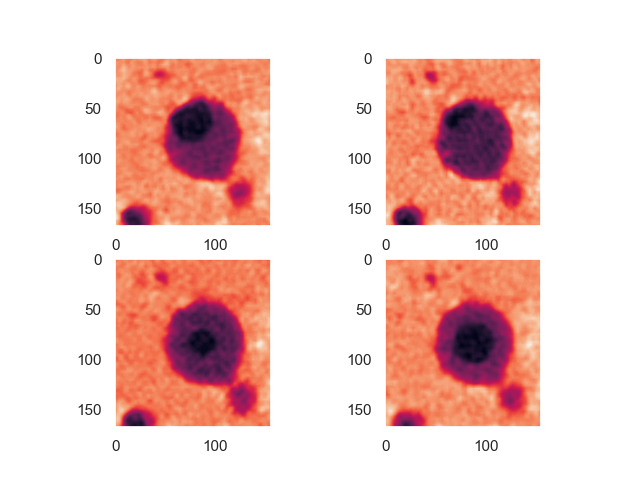

In [2]:
showslice = 70
im0 = tifffile.imread('data/bubble_0.tif')[showslice]
im1 = tifffile.imread('data/bubble_1.tif')[showslice]
im2 = tifffile.imread('data/bubble_2.tif')[showslice]
im3 = tifffile.imread('data/bubble_3.tif')[showslice]


fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(im0)
ax[0, 1].imshow(im1)
ax[1, 0].imshow(im2)
ax[1, 1].imshow(im3)

ims = [im0, im1, im2, im3]
ref_im = im0
evo_im = im2

## Step 3: Creating the 2D histogram
We create a 2D histogram where the grayscale from the reference and evolved images are binned on the x and y axis, respectively. The clustering is influenced by the number of bins in the histogram, but only to a small extent. Something like 64 bins in each dimension is probably fine.

The idea behind the 2D histogram is that regions of the sample which are not evolving will appear along the diagonal of the histogram. For multiphase materials each materials will ideally form a cluster. The off-diagonal bins in the histogram corresponds to evolution of the grayscale. The region below the diagonal is regions where the grayscale is lower (i.e. darker) in the evolved image and the region above the diagonal is regions which are brighter in the evolved image. By clustering the 2D histogram and mapping back to the sample images we can segment both material phases and microstruture evolution.

Text(0, 0.5, 'Evolved image')

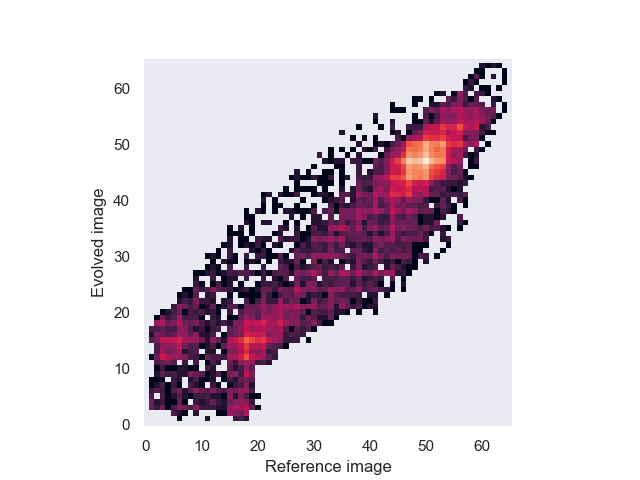

In [7]:
nbins = 64  # number of bins in each direction
H, ic, jc = evosegment.make2DHistogram(ref_im, evo_im, nbins)

plt.figure()
plt.imshow(H, origin='lower', norm=colors.LogNorm())
plt.xlabel('Reference image')
plt.ylabel('Evolved image')

## Step 4: Generate  cluster postitions 
The easiest way to generate the cluster positions is to use the `PickClusters` class. This will show a plot of the 2D histogram where cluster positions can be added by clicking. Each bin in the joint histogram is then assigned the label of the nearest cluster position. The figure remains active until the kernel stops, so it is easy to add additional clusters later. Running the cell again will reset the cluster positions. 

An alternative method for generating clusters is to use the `PolygonClusters` class. This allows drawing polygons around clusters in the 2D histogram. Here each cluster is defined manually by drawing a polygon around it. This is useful e.g. if the clusters have irregular shapes.

evoSegment also includes two algorithms for automatically finding clusters:
`evosegment.subtractive_mountain_clustering` and `evosegment.detectClusterCenters`. These are described in the paper. 

The cluster positions can be refined using kmeans (`evosegment.kmeans_clustering`). This, however, usually doesn't help much since the clusters typically are of different size and not circular.

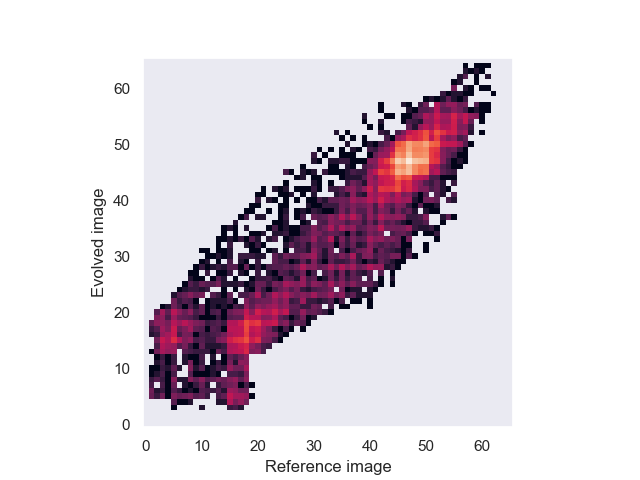

In [ ]:
#Clusters defined by clicking point in the histogram
fig, ax = plt.subplots()
ax.imshow(H, origin='lower', norm=colors.LogNorm())
plt.xlabel('Reference image')
plt.ylabel('Evolved image')

c = evosegment.PickClusters(fig, 5)
c.connect()

In [ ]:
centroids = np.array(c.centroid)
nclusters = len(centroids)

print("Number of clusters:", nclusters)
print("Cluster centroids:", centroids)
vertices = None #we dont need vertices if using picked centroids

Number of clusters: 5
Cluster centroids: [[47.39285714 46.07142857]
 [16.14285714 17.85714286]
 [ 5.07142857 16.42857143]
 [ 5.25        5.35714286]
 [17.75        4.10714286]]


Draw polygons around clusters. Close the polygon by clicking on the starting point. Press 'esc' to start a new polygon.


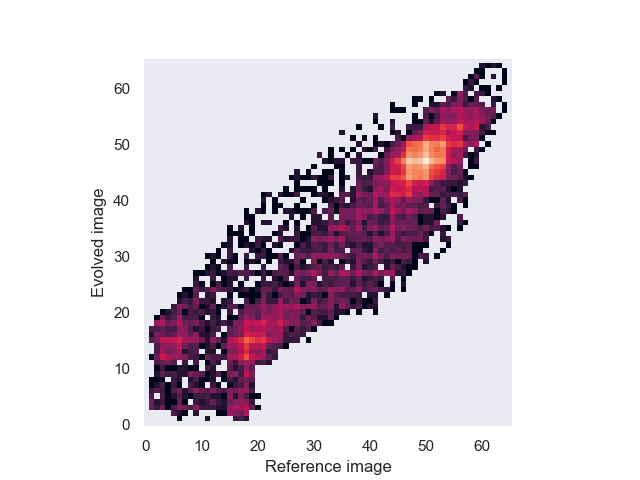

In [10]:
#Clusters defined by drawing polygons in the histogram
fig, ax = plt.subplots()
ax.imshow(H, origin='lower', norm=colors.LogNorm())
plt.xlabel('Reference image')
plt.ylabel('Evolved image')

p = evosegment.PolygonClusters(fig)
centroids = None #we dont need centroids if using drawn polygons

## Step 5: Label the histogram
With the cluster positions identified we can label each bin in the histogram based on the closest cluster position. We also generate a nice colormap for the segmentation.

Text(0, 0.5, 'Evolved image')

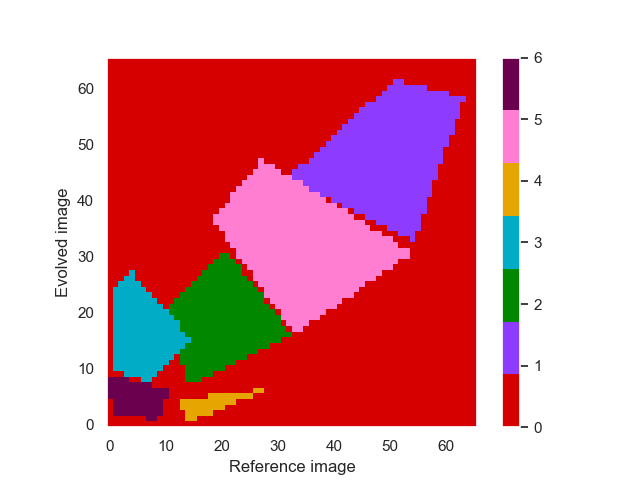

In [24]:
labels, cmap = evosegment.labelHistogram(H, vertices=p.vertices,centroids=centroids, make_cmap=True)
plt.figure()
plt.imshow(labels, cmap=cmap, origin='lower', interpolation='none')
plt.colorbar()
plt.xlabel('Reference image')
plt.ylabel('Evolved image')

## Step 6: Label the images based on the clustered histogram
We now assign the labels from the histogram to each voxel based on the grayscale pair $(ref, evolved)$

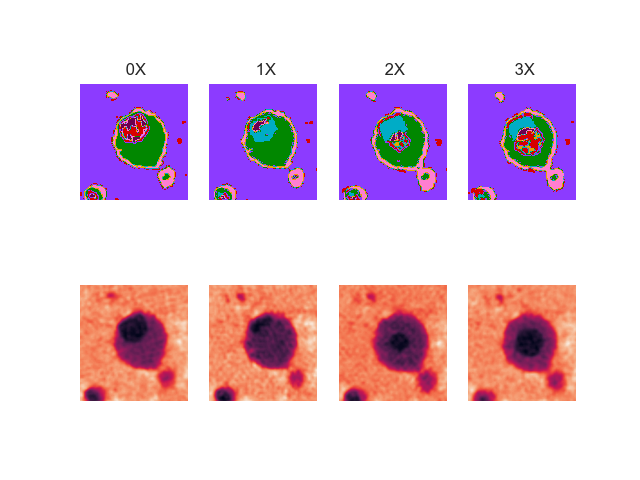

In [25]:
fig, ax = plt.subplots(2, 4, sharey=True, sharex=True)
axs = ax.ravel()
titles = [f'{i:2d}X' for i in range(4)]
for i, im in enumerate(ims):
    l = evosegment.paintVolume(im0, im, labels, ic, jc, nprocs=8)
    axs[i].imshow(l, cmap=cmap, vmin=0, vmax=labels.max()+1)
    axs[i].set_title(titles[i])
    axs[i].axis('off')
    axs[i + 4].imshow(im)
    axs[i + 4].axis('off')